In [1]:
%load_ext autoreload
%autoreload 2

import os
import hydromt
import hydromt_summa
from hydromt_summa.summa import SummaModel
from hydromt import workflows, flw
import xarray as xr
from hydromt.log import setuplog
import numpy as np

/home/ayx374/.local/easybuild/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(
/home/ayx374/.local/easybuild/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
from dask import delayed
from dask_mpi import initialize

def elapsed(start):
    return str(time.time() - start) + ' seconds'

In [3]:
data_catalogue_path = os.path.join(os.path.expanduser("~"),'projects','rpp-kshook','CompHydCore','datacatalog.yml')
root = os.path.join('./summa_bowatbanff_dask')
mod = SummaModel(root=root, mode="w",
                  data_libs=[data_catalogue_path])

Model dir already exists and files might be overwritten: /home/ayx374/Github/hydromt_summa/examples/graham/summa_bowatbanff_dask/response_units.
Model dir already exists and files might be overwritten: /home/ayx374/Github/hydromt_summa/examples/graham/summa_bowatbanff_dask/output.


In [4]:
_region = {'geom': './test_shapes/bow_distributed_elevation_zone.shp'}
r = mod.setup_region(_region)

In [5]:
mod.setup_response_unit(
    hydrography_fn="merit_hydro",
    split_regions = False,
    index_col = "HRU_ID",
    
)
mod.set_response_units(mod.response_units.sortby(['GRU_ID','HRU_ID']))
mod.response_units

<xarray.Dataset>
Dimensions:      (index: 118)
Coordinates:
  * index        (index) int64 48 97 118 1 49 100 2 50 ... 93 45 94 46 95 47 96
    geometry     (index) object POLYGON ((-115.57375 51.150416663845334, -115...
    spatial_ref  int64 0
Data variables:
    GRU_ID       (index) object '71028585' '71028585' ... '71032440' '71032440'
    HRU_ID       (index) int64 48 97 118 1 49 100 2 50 ... 93 45 94 46 95 47 96
    center_lat   (index) float64 51.15 51.16 51.17 51.19 ... 51.65 51.67 51.66
    center_lon   (index) float64 -115.6 -115.6 -115.6 ... -116.3 -116.5 -116.4
    HRU_area     (index) float64 5.081e+05 1.616e+06 ... 8.694e+07 2.007e+07

In [16]:
ds = mod.data_catalog.get_rasterdataset('era5_for_summa',geom=mod.region,time_tuple=('2008-01-01 00:00','2008-12-31'),parallel=True)

In [17]:
ds.pptrate

<xarray.DataArray 'pptrate' (time: 8784, latitude: 3, longitude: 4)>
dask.array<getitem, shape=(8784, 3, 4), dtype=float32, chunksize=(744, 3, 4), chunktype=numpy.ndarray>
Coordinates:
  * longitude    (longitude) float32 -116.5 -116.2 -116.0 -115.8
  * latitude     (latitude) float32 51.5 51.25 51.0
  * time         (time) datetime64[ns] 2008-01-01 ... 2008-12-31T23:00:00
    spatial_ref  int64 1
    mask         (latitude, longitude) bool False True False ... False False
Attributes:
    units:          kg m**-2 s**-1
    long_name:      Mean total precipitation rate
    standard_name:  n/a

In [18]:
task = ds.to_netcdf(os.path.join(mod.root,'subERA5.nc'),compute=False)

NotImplementedError: Writing netCDF files with the scipy backend is not currently supported with dask's distributed scheduler

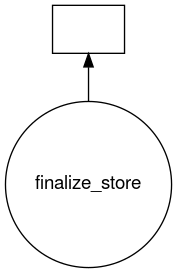

In [22]:
task.visualize()

In [28]:
dsf = xr.open_dataset('/home/ayx374/projects/rpp-kshook/CompHydCore/climateForcingData/ERA5/ERA5_for_SUMMA/2_merged_data/ERA5_merged_198003.nc')

In [23]:
datasets = list(hydromt_summa.summa.split_by_chunks(ds))        
paths = [hydromt_summa.summa.create_filepath(ds,'forcing',mod.root) for ds in datasets]

In [28]:
task2 = xr.save_mfdataset(datasets=datasets, paths=paths,engine="h5netcdf",compute=False)

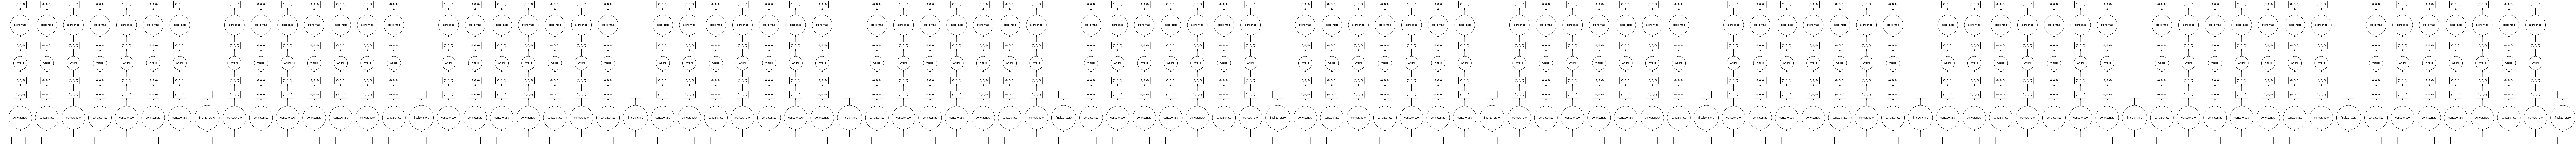

In [29]:
task2.visualize()

In [42]:
cluster = SLURMCluster(project='rpp-kshook',
                      cores=1,
                      memory="1000MB",
                   walltime='01:00:00')
client = Client(cluster)

In [43]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.29.84.158:38566/status,
Dashboard: http://10.29.84.158:38566/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.29.84.158:43012,Workers: 0
Dashboard: http://10.29.84.158:38566/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [44]:
print(cluster.job_script())

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -A rpp-kshook
#SBATCH -n 1
#SBATCH --cpus-per-task=1
#SBATCH --mem=954M
#SBATCH -t 01:00:00

/home/ayx374/venvs/hydromt-env/bin/python -m distributed.cli.dask_worker tcp://10.29.84.158:43012 --nthreads 1 --memory-limit 0.93GiB --name dummy-name --nanny --death-timeout 60



In [46]:
cluster.scale(12)

In [47]:
!squeue -u $USER

            JOBID     USER              ACCOUNT           NAME  ST  TIME_LEFT NODES CPUS TRES_PER_N MIN_MEM NODELIST (REASON) 
         65083117   ayx374       rpp-kshook_cpu    dask-worker   R      52:55     1    1        N/A    954M gra633 (None) 
         65083118   ayx374       rpp-kshook_cpu    dask-worker   R      52:56     1    1        N/A    954M gra638 (None) 
         65083119   ayx374       rpp-kshook_cpu    dask-worker   R      52:56     1    1        N/A    954M gra638 (None) 
         65083120   ayx374       rpp-kshook_cpu    dask-worker   R      52:56     1    1        N/A    954M gra638 (None) 
         65083121   ayx374       rpp-kshook_cpu    dask-worker   R      52:56     1    1        N/A    954M gra638 (None) 
         65083122   ayx374       rpp-kshook_cpu    dask-worker   R      52:56     1    1        N/A    954M gra1103 (None) 
         65083123   ayx374       rpp-kshook_cpu    dask-worker   R      52:59     1    1        N/A    954M gra614 (None) 
         65

In [48]:
import time
time1 = time.time()
task2.compute()
print('Result computed:', elapsed(time1))

Result computed: 13.922868013381958 seconds


In [50]:
ds2 = mod.data_catalog.get_rasterdataset('era5_for_summa',geom=mod.region,time_tuple=('2008-01-01 00:00','2010-12-31'),parallel=True)
ds2.pptrate

<xarray.DataArray 'pptrate' (time: 26304, latitude: 3, longitude: 4)>
dask.array<getitem, shape=(26304, 3, 4), dtype=float32, chunksize=(744, 3, 4), chunktype=numpy.ndarray>
Coordinates:
  * longitude    (longitude) float32 -116.5 -116.2 -116.0 -115.8
  * latitude     (latitude) float32 51.5 51.25 51.0
  * time         (time) datetime64[ns] 2008-01-01 ... 2010-12-31T23:00:00
    spatial_ref  int64 1
    mask         (latitude, longitude) bool False True False ... False False
Attributes:
    units:          kg m**-2 s**-1
    long_name:      Mean total precipitation rate
    standard_name:  n/a

In [51]:
datasets = list(hydromt_summa.summa.split_by_chunks(ds2))        
paths = [hydromt_summa.summa.create_filepath(ds2,'forcing',mod.root) for ds2 in datasets]
task3 = xr.save_mfdataset(datasets=datasets, paths=paths,engine="h5netcdf",compute=False)

In [52]:
# with 12 workers
time2 = time.time()
task3.compute()
print('Result computed:', elapsed(time2))

Result computed: 113.17615151405334 seconds


In [53]:
# with number of chunks
cluster.scale(36)
time3 = time.time()
task3.compute()
print('Result computed:', elapsed(time3))

Result computed: 38.1669135093689 seconds


In [60]:
# kill client and workers
client.shutdown()

In [61]:
# new client
cluster = SLURMCluster(project='rpp-kshook',
                      cores=1,
                      memory="1000MB",
                   walltime='01:00:00')
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.29.84.158:35111/status,
Dashboard: http://10.29.84.158:35111/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.29.84.158:44833,Workers: 0
Dashboard: http://10.29.84.158:35111/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [64]:
# start with 4 workers
cluster.scale(4)

In [65]:
mod.setup_forcing('era5_for_summa', get_rasterdataset_kwargs = {'time_tuple':('2008-01-01 00:00','2008-12-31'),'parallel':True}, all_touched=True)
mod.forcing['LWRadAtm_mean']

<xarray.DataArray 'LWRadAtm_mean' (index: 118, time: 8784)>
dask.array<concatenate, shape=(118, 8784), dtype=float32, chunksize=(1, 744), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2008-01-01 ... 2008-12-31T23:00:00
    spatial_ref  int64 1
  * index        (index) int64 48 97 118 1 49 100 2 50 ... 93 45 94 46 95 47 96

In [67]:
import time
time2 = time.time()
mod.write_forcing()
print('Result computed with 4 workers:', elapsed(time2))

Result computed with 4 workers: 52.61873936653137 seconds


In [68]:
# now with 12 workers
cluster.scale(12)
mod.setup_forcing('era5_for_summa', get_rasterdataset_kwargs = {'time_tuple':('2008-01-01 00:00','2008-12-31'),'parallel':True}, all_touched=True)
mod.forcing['LWRadAtm_mean']


<xarray.DataArray 'LWRadAtm_mean' (index: 118, time: 8784)>
dask.array<concatenate, shape=(118, 8784), dtype=float32, chunksize=(1, 744), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2008-01-01 ... 2008-12-31T23:00:00
    spatial_ref  int64 1
  * index        (index) int64 48 97 118 1 49 100 2 50 ... 93 45 94 46 95 47 96

In [69]:
import time
time3 = time.time()
mod.write_forcing()
print('Result computed with 12 workers:', elapsed(time3))

Result computed with 12 workers: 45.384382247924805 seconds


In [70]:
# now for multiple years
# same ratio of workers
cluster.scale(48)
mod.setup_forcing('era5_for_summa', get_rasterdataset_kwargs = {'time_tuple':('2008-01-01 00:00','2011-12-31'),'parallel':True}, all_touched=True)
mod.forcing['LWRadAtm_mean']

<xarray.DataArray 'LWRadAtm_mean' (index: 118, time: 35064)>
dask.array<concatenate, shape=(118, 35064), dtype=float32, chunksize=(1, 744), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2008-01-01 ... 2011-12-31T23:00:00
    spatial_ref  int64 1
  * index        (index) int64 48 97 118 1 49 100 2 50 ... 93 45 94 46 95 47 96

In [71]:
import time
time3 = time.time()
mod.write_forcing()
print('Result computed for 4 years with 48 workers (12 per year, 1 per month):', elapsed(time3))

Result computed for 4 years with 48 workers (12 per year, 1 per month): 378.8475658893585 seconds


In [72]:
# note on the above: only 12 workers available at first, later 22

In [73]:
client.shutdown()

2022-09-09 14:29:20,233 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [94]:
# new client
cluster = SLURMCluster(project='rpp-kshook',
                      cores=12,
                      memory="12000MB",
                   walltime='00:15:00')
client = Client(cluster)
print(cluster.job_script())

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -A rpp-kshook
#SBATCH -n 1
#SBATCH --cpus-per-task=12
#SBATCH --mem=12G
#SBATCH -t 00:15:00

/home/ayx374/venvs/hydromt-env/bin/python -m distributed.cli.dask_worker tcp://10.29.84.158:33096 --nthreads 3 --nworkers 4 --memory-limit 2.79GiB --name dummy-name --nanny --death-timeout 60



In [95]:
# now for multiple years
# same ratio of workers
cluster.scale(1)

In [96]:
mod.setup_forcing('era5_for_summa', get_rasterdataset_kwargs = {'time_tuple':('2008-01-01 00:00','2008-12-31'),'parallel':True}, all_touched=True)
mod.forcing['LWRadAtm_mean']

<xarray.DataArray 'LWRadAtm_mean' (index: 118, time: 8784)>
dask.array<concatenate, shape=(118, 8784), dtype=float32, chunksize=(1, 744), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2008-01-01 ... 2008-12-31T23:00:00
    spatial_ref  int64 1
  * index        (index) int64 48 97 118 1 49 100 2 50 ... 93 45 94 46 95 47 96

In [97]:
import time
time3 = time.time()
mod.write_forcing()
print('Result computed for 1 year with 12 workers (12 per year, 1 per month):', elapsed(time3))

Result computed for 1 year with 12 workers (12 per year, 1 per month): 83.6962239742279 seconds


In [98]:
client.shutdown()

2022-09-09 15:15:24,806 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [7]:
# new client
cluster = SLURMCluster(project='rpp-kshook',
                      cores=24,
                      memory="24000MB",
                   walltime='00:15:00')
client = Client(cluster)
print(cluster.job_script())

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -A rpp-kshook
#SBATCH -n 1
#SBATCH --cpus-per-task=24
#SBATCH --mem=23G
#SBATCH -t 00:15:00

/home/ayx374/venvs/hydromt-env/bin/python -m distributed.cli.dask_worker tcp://10.29.84.159:43159 --nthreads 4 --nworkers 6 --memory-limit 3.73GiB --name dummy-name --nanny --death-timeout 60



In [10]:
# now for multiple years
# same ratio of workers
cluster.scale(1)

In [11]:
mod.setup_forcing('era5_for_summa', get_rasterdataset_kwargs = {'time_tuple':('2008-01-01 00:00','2011-12-31'),'parallel':True}, all_touched=True)
mod.forcing['LWRadAtm_mean']

<xarray.DataArray 'LWRadAtm_mean' (index: 118, time: 35064)>
dask.array<concatenate, shape=(118, 35064), dtype=float32, chunksize=(1, 744), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2008-01-01 ... 2011-12-31T23:00:00
    spatial_ref  int64 1
  * index        (index) int64 48 97 118 1 49 100 2 50 ... 93 45 94 46 95 47 96

In [12]:
import time
time3 = time.time()
mod.write_forcing()
print('Result computed for 4 year with 24 workers (6 per year, 1 per 2 month):', elapsed(time3))

Result computed for 4 year with 24 workers (6 per year, 1 per 2 month): 541.3392696380615 seconds


In [ ]:
client.shutdown()

In [15]:
# new client, same cores, but all just one process
cluster = SLURMCluster(project='rpp-kshook',
                      cores=24,
                    processes=1,
                      memory="24000MB",
                   walltime='00:15:00')
client = Client(cluster)
print(cluster.job_script())

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -A rpp-kshook
#SBATCH -n 1
#SBATCH --cpus-per-task=24
#SBATCH --mem=23G
#SBATCH -t 00:15:00

/home/ayx374/venvs/hydromt-env/bin/python -m distributed.cli.dask_worker tcp://10.29.84.159:39031 --nthreads 24 --memory-limit 22.35GiB --name dummy-name --nanny --death-timeout 60



In [16]:
# now for multiple years
# same ratio of workers
cluster.scale(1)

In [17]:
mod.setup_forcing('era5_for_summa', get_rasterdataset_kwargs = {'time_tuple':('2008-01-01 00:00','2011-12-31'),'parallel':True}, all_touched=True)
mod.forcing['LWRadAtm_mean']

<xarray.DataArray 'LWRadAtm_mean' (index: 118, time: 35064)>
dask.array<concatenate, shape=(118, 35064), dtype=float32, chunksize=(1, 744), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2008-01-01 ... 2011-12-31T23:00:00
    spatial_ref  int64 1
  * index        (index) int64 48 97 118 1 49 100 2 50 ... 93 45 94 46 95 47 96

In [18]:
import time
time3 = time.time()
mod.write_forcing()
print('Result computed for 4 year with 24 workers, individual processes (6 per year, 1 per 2 month):', elapsed(time3))

Result computed for 4 year with 24 workers, individual processes (6 per year, 1 per 2 month): 738.6867685317993 seconds


In [ ]:
client.shutdown()

In [6]:
# new client, one core, one process, in serial, direct start.
cluster = SLURMCluster(project='rpp-kshook',
                      cores=1,
                    processes=1,
                      memory="1000MB",
                   walltime='00:20:00')
client = Client(cluster)
print(cluster.job_script())

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -A rpp-kshook
#SBATCH -n 1
#SBATCH --cpus-per-task=1
#SBATCH --mem=954M
#SBATCH -t 00:20:00

/home/ayx374/venvs/hydromt-env/bin/python -m distributed.cli.dask_worker tcp://10.29.84.159:36687 --nthreads 1 --memory-limit 0.93GiB --name dummy-name --nanny --death-timeout 60



In [7]:
# now for multiple years
# same ratio of workers
cluster.scale(900) # go for the maximum!

In [10]:
mod.setup_forcing('era5_for_summa', get_rasterdataset_kwargs = {'time_tuple':('2008-01-01 00:00','2013-12-31'),'parallel':True}, all_touched=True)
mod.forcing['LWRadAtm_mean']

<xarray.DataArray 'LWRadAtm_mean' (index: 118, time: 52608)>
dask.array<concatenate, shape=(118, 52608), dtype=float32, chunksize=(1, 744), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2008-01-01 ... 2013-12-31T23:00:00
    spatial_ref  int64 1
  * index        (index) int64 48 97 118 1 49 100 2 50 ... 93 45 94 46 95 47 96

In [11]:
import time
time3 = time.time()
mod.write_forcing()
print('Result computed for 6 year with # workers based on scheduler (max 900):', elapsed(time3))

Result computed for 6 year with # workers based on scheduler (max 900): 399.665158033371 seconds


In [ ]:
# after 4 minutes - 10 nodes running
# after 13 minutes - 30 nodes running
# Result computed for 6 year with # workers based on scheduler (max 900): 959.8213772773743 seconds (from cold start) c.a. 16 min

In [ ]:
# start with 40 nodes running (some have 8 min left)
# after 2 min still 40 nodes
# after 4 min 50 nodes
# after 6 minutes 40 nodes
# Result computed for 6 year with # workers based on scheduler (max 900): 399.665158033371 seconds (6 min 40 s)